In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
stock = pd.read_csv('BBCA.csv')
stock = stock.set_index('Date')
show = stock.head()
show = show.append(stock.tail())
show

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,13275.0,13275.0,13150.0,13225.0,12520.961914,5860500.0
2015-01-05,13150.0,13200.0,13125.0,13200.0,12497.292969,5086900.0
2015-01-06,13000.0,13200.0,13000.0,13100.0,12402.616211,9736300.0
2015-01-07,13050.0,13200.0,13050.0,13125.0,12426.286133,8066800.0
2015-01-08,13125.0,13150.0,12975.0,12975.0,12284.270508,10891400.0
2019-11-08,31575.0,31575.0,31250.0,31400.0,31400.000000,18008100.0
2019-11-11,31675.0,31700.0,31325.0,31475.0,31475.000000,14041400.0
2019-11-12,31100.0,31400.0,31100.0,31325.0,31325.000000,9527100.0
2019-11-13,31325.0,31425.0,31325.0,31400.0,31400.000000,8016700.0


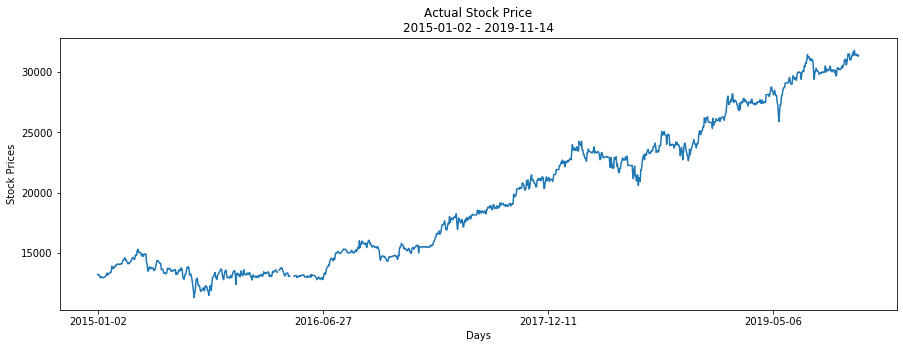

In [4]:
plt.figure(figsize = (15, 5))
plt.title('Actual Stock Price\n' + str(stock.index.min()) + ' - ' + str(stock.index.max()))
plt.plot(stock.index, stock['Close'])
plt.xticks(stock.index[::365], stock.index[::365])
plt.xlabel('Days')
plt.ylabel('Stock Prices')
plt.show()

In [5]:
start_date = '2015-01-02'
end_date = '2018-12-31'

# start_date and end_date is the interval of past stock prices that is going to be used to predict future stocks

pred_start_date = '2019-01-01'
pred_end_date = '2019-11-14'

# pred_start_date and pred_end_date is the interval of stock prices that is going to be predicted

pastdf = stock['Close'][start_date:end_date]
showpast = pastdf.head(2)
showpast = showpast.append(pastdf.tail(2))

# pastdf is the dataframe of the past closing stocks with the interval of 1 trading day.

print('Historical Stock Prices')
showpast

Historical Stock Prices


Date
2015-01-02    13225.0
2015-01-05    13200.0
2018-12-28    26000.0
2018-12-31    26000.0
Name: Close, dtype: float64

In [6]:
S0 = pastdf[pastdf.shape[0]-1]
# S0 represents initial stock price
dt = 1
# dt represents time increment (1 day)
sum_wkdy = pd.date_range(start = pd.to_datetime(end_date, 
              format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
              end = pd.to_datetime(pred_end_date, 
              format = "%Y-%m-%d")).to_series(
              ).map(lambda x: 
              1 if x.isoweekday() in range(1,6) else 0).sum()
T = sum_wkdy
# T represents length of prediction time
N = T/dt
# N represents the count of changes in stock prices
t = np.arange(1, int(N)+1)
# t represents time points of N
streturn = (stock.loc[start_date:end_date, 'Close'] - \
            stock.shift(1).loc[start_date:end_date, 'Close']) / \
            stock.shift(1).loc[start_date:end_date, 'Close']
# streturn represents daily returns of the closing price
mu = np.mean(streturn)
# mu represents the average return of the historical date range
stdev = np.std(streturn)
# stdev represents standard deviation return of the historical date range
scen_size = 200
# scen_size represents the total of predictions that is going to be made
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
# b represents random normal distribution number to add random shocks
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}
# W represents Brownian path to sum the random normal distribution number. It makes a path
drift = (mu - 0.5 * stdev**2) * t
diffusion = {str(scen): stdev * W[str(scen)] for scen in range(1, scen_size + 1)}
S = np.array([S0 * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[S0] for scen in range(scen_size)]), S))
# S represents the final prediction for the stock, contain prediction as much as scen_size
F=S[0]
for n in range(scen_size) :
    F=F+S[n]
for n in range(len(F)) :
    F[n] = F[n]/scen_size
# F represents the average of S

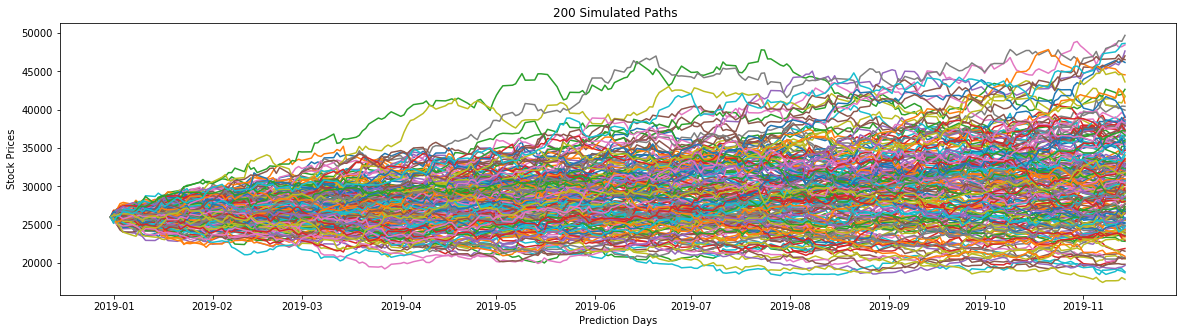

In [7]:
plt.figure(figsize = (20,5))

for i in range(scen_size):
    plt.title("200 Simulated Paths ")
    plt.plot(pd.date_range(start = end_date , 
                end = pred_end_date, freq = 'D').map(lambda x:
                x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices')
    plt.xlabel('Prediction Days')
    
plt.show()

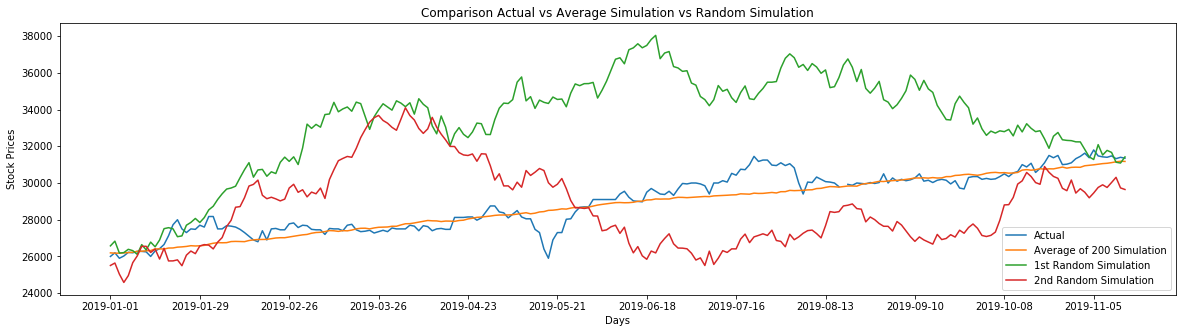

In [8]:
compare = stock['Close'][pred_start_date:pred_end_date]
plt.figure(figsize = (20, 5))
plt.title('Comparison Actual vs Average Simulation vs Random Simulation')
plt.plot(compare.index, compare, label='Actual')
plt.plot(compare.index, F[1:], label='Average of 200 Simulation')
plt.plot(compare.index, S[0][1:], label='1st Random Simulation')
plt.plot(compare.index, S[1][1:], label='2nd Random Simulation')
plt.legend(loc='lower right')
plt.xticks(compare.index[::20], compare.index[::20])
plt.xlabel('Days')
plt.ylabel('Stock Prices')
plt.show()